## Example of Trans-C sampling across independent model states: State-Jump Sampler with Walker Pool Parallelization

This notebook demonstrates Bayesian sampling of a linear polynomial regression problem using the State-Jump sampler either in serial mode or with walker pool parallelization. 

In [1]:
# general python utility packages
import time
from collections import Counter
from functools import partial
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

import corner
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize

%matplotlib inline

In [2]:
from pytransc.analysis.samples import get_transc_samples
from pytransc.analysis.visits import (
    count_state_changes,
    count_total_state_changes,
    get_acceptance_rate_between_states,
    get_autocorr_between_state_jumps,
    get_relative_marginal_likelihoods,
    get_visits_to_states,
)
from pytransc.samplers import run_state_jump_sampler, run_mcmc_per_state
from pytransc.utils.auto_pseudo import PseudoPriorBuilders, build_auto_pseudo_prior

In [3]:
%%writefile regression_functions.py
"""
Regression example functions for Trans-C sampling.

These functions are defined in a separate module to ensure compatibility
with multiprocessing on macOS and Windows, which use 'spawn' instead of 'fork'.
"""

import numpy as np
import scipy.stats as stats
rng = np.random.default_rng(42)


def solveLS(d, G, Cdinv, mu=None, Cmpriorinv=None):
    """Solve the least squares problem given data, design matrix, and covariance matrices."""
    A = np.dot(np.transpose(G), Cdinv)  # Find solution
    GtG = np.dot(A, G)  # G^T C_inv G^T
    if (Cmpriorinv is not None) and (mu is not None):
        GtG += Cmpriorinv
    GtGinv = np.linalg.inv(GtG)  # Inverse of G^TC_inv G
    B = np.dot(A, d)
    if (Cmpriorinv is not None) and (mu is not None):
        B += np.dot(Cmpriorinv, mu)
    mls = np.dot(GtGinv, B)
    return mls, GtGinv


def calcE(dp, dobs, Cdinv, Cmpost, m, muprior, Cmpriorinv):
    """Calculate the evidence for the model given data, prior, and posterior covariances."""
    misfit = 0.5 * (np.dot((dobs - dp), np.dot(Cdinv, (dobs - dp))))
    misfit += 0.5 * (np.dot((muprior - m), np.dot(Cmpriorinv, (muprior - m))))
    f = np.sqrt(2 * np.pi) ** len(dp)
    detCdinv = np.linalg.det(Cdinv)
    detCmpost = np.linalg.det(Cmpost)
    detCmpriorinv = np.linalg.det(Cmpriorinv)
    E = np.sqrt(detCmpost * detCdinv * detCmpriorinv) * np.exp(-misfit) / f
    return E


def getG(x, order):
    """Build design matrix, G for polynomial data fitting, at data points x up to order order."""
    return np.transpose([x ** (i) for i in range(order + 1)])


def _log_likelihood(x, state, dobs, G, Cdinv):
    """Calculate the log likelihood of the data given the model parameters."""
    dpred = np.dot(G[state], x)
    misfit = 0.5 * (np.dot((dobs - dpred), np.dot(Cdinv, (dobs - dpred))))
    f = np.sqrt(2 * np.pi) ** len(dpred)
    detCdinv = np.linalg.det(Cdinv)
    logL = -np.log(f) - misfit + np.log(detCdinv)
    return logL


def _log_prior(x, state, muprior, Cmprior):
    """Calculate the log prior probability of the model parameters."""
    mu = muprior[state]
    cov = Cmprior[state]
    rv = stats.multivariate_normal(
        mean=mu, cov=cov
    )  # instance of multi-dimensional Gaussian
    return rv.logpdf(x)


def log_posterior(x, state, dobs, G, Cdinv, muprior, Cmprior):
    """Multi-state log Posterior PDF evaluation (unnormalized)."""
    log_likelihood = _log_likelihood(x, state, dobs, G, Cdinv)
    log_prior = _log_prior(x, state, muprior, Cmprior)
    return log_likelihood + log_prior

# define model proposal for within state moves

class IsotropicGaussianProposal:
    """Class for isotropic Gaussian proposal for state jump sampler."""
    rng = np.random.default_rng(42)

    def __init__(self):
        self.std = [
            [0.01],
            [0.04, 0.05],
            [0.04, 0.2, 0.2],
            [0.05, 0.5, 1.0, 1.0],
        ]  # Proposal variance for each parameter in state

    def __call__(self, x: np.ndarray, state: int) -> float:
        """Call method to generate proposal."""
        return 0.0  # log ratio for symmetric proposal

    def propose(self, x: np.ndarray, state: int) -> np.ndarray:
        """Propose from the proposal distribution."""
        i = rng.choice(np.arange(len(x)))
        var = self.std[state][i] ** 2
        _x = np.copy(x)
        _x[i] += stats.multivariate_normal.rvs(mean=0.0, cov=var)
        if not isinstance(_x, np.ndarray):
            _x = np.array([_x])  # deal with 1D case which returns a scalar
        return _x

Overwriting regression_functions.py


In [4]:
# Import the functions we just wrote to the module
from regression_functions import (
    solveLS,
    calcE,
    getG,
    _log_likelihood,
    _log_prior,
    log_posterior as _log_posterior_full,
    IsotropicGaussianProposal,
)

### Cross-platform multiprocessing compatibility

**Note on macOS/Windows compatibility:** The functions below are defined in a separate module to ensure compatibility with multiprocessing on macOS and Windows.

- **Why?** macOS and Windows use `spawn` for multiprocessing (not `fork` like Linux)
- **What does this mean?** Functions must be picklable (defined at module level, not inline in notebooks)
- **Solution:** We use `%%writefile` to create a module file while keeping the code visible in the notebook

This ensures the notebook works on Linux, macOS, and Windows without modification.

--------

## Polynomial regression theory

Here we set up a problem of polynomial regression fitting a set of x,y data with up to a 4th order polynomial.

To begin with, we will work with polynomial curves, $$y(x) = \sum_{n=0}^N m_n x^n\,.$$
Here, $N$ is the 'order' of the polynomial: if $N=1$ we have a straight line, if $N=2$ it will be a quadratic, and so on. The $m_n$ are the 'model coefficients'.

To compute $y(x)$ for multiple $x$-values simultaneously, we  write $$ \left(\begin{array}{c}y_1\\y_2\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_1&x_1^2\\1&x_2&x_2^2\\\vdots&\vdots&\vdots\\1&x_N&x_N^2\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$This has the general form, $\mathbf{d=Gm}$, and so the best-fitting model can be identified using a least-squares algorithm.

The maximum Likelihood solution for this problem is the model which minimizes

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}),
$$
which leads to

$$
{\bf m}_{LS} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G}\right)^{-1}\mathbf{G}^T  C_D^{-1} \mathbf{d}.
$$

The *MAP* model, $\hat{{\bf m}}$, for this problem minimizes of the sum of the negative log-Likelihood and log-Gaussian prior 

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}) + \frac{1}{2} (\mathbf{m - m_o})^TC_M^{-1} (\mathbf{m - m_o})
$$

which leads to

$$
\hat{{\bf m}} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}(\mathbf{G}^T  C_D^{-1} \mathbf{d} + C_M^{-1}\mathbf{m_o}).
$$

For Gaussian Likelihood and prior the evidence is a known analytical expression.

$$
p{(\bf d}) = \frac{e^{-\phi(\hat{{\bf m}})}}{(2\pi)^{N/2}} \left[ \frac{|\hat{C}_M|}{|C_D||C_M|}\right]^{1/2}.
$$
where $\hat{C}_M$ is the posterior model covariance, 

$$
\hat{C}_M = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}
$$

We generate some random samples from $y=3x/5+0.3$, add Gaussian random noise to them.

In [5]:
np.random.seed(61254557)  # noqa: NPY002
ndata, sigma = 20, 0.2
xobs = np.sort(np.random.rand(ndata))  # noqa: NPY002 ; x values of data
mtrue = np.array([0.3, 0.6])
G = getG(xobs, 1)
dobs = np.dot(G, mtrue) + np.random.normal(0, sigma, size=len(xobs))  # noqa: NPY002
Cdinv = np.eye(ndata) / (sigma**2)

Set up prior for Evidence calculation.

In [6]:
mls = []
Cmpost = []
G = []
Ev = []
maxorder = 3
Cmprior = [20 * np.eye(i + 1) for i in np.arange(maxorder + 1)]
Cmpriorinv = [0.05 * np.eye(i + 1) for i in np.arange(maxorder + 1)]
muprior = [np.zeros(i + 1) for i in np.arange(maxorder + 1)]

Solve least squares solution and calculate evidence for each model.

In [7]:
for i in range(maxorder + 1):
    Gp = getG(xobs, i)
    solp, Cmp = solveLS(dobs, Gp, Cdinv)  # Maximum Likelihood solution
    dpred = np.dot(Gp, solp)
    mls.append(solp)
    Cmpost.append(Cmp)
    G.append(Gp)
    solp2, Cmp2 = solveLS(
        dobs, Gp, Cdinv, mu=muprior[i], Cmpriorinv=Cmpriorinv[i]
    )  # MAP model and model covariance with Gaussian prior
    dpred2 = np.dot(Gp, solp2)
    Ev.append(
        calcE(dpred2, dobs, Cdinv, Cmp2, solp2, muprior[i], Cmpriorinv[i])
    )  # Analytical evidence calculation
Ev /= np.sum(Ev)

Plot solutions.

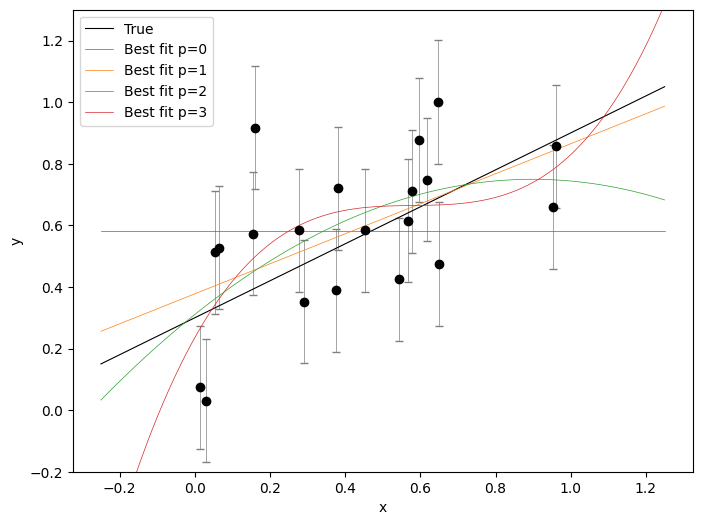

In [8]:
xplot = np.linspace(-0.25, 1.25, 100)
Gplot = getG(xplot, 1)
dplot = np.dot(Gplot, mtrue)
#
plt.figure(figsize=(8, 6))
plt.errorbar(xobs, dobs, yerr=sigma, capsize=3, fmt="ko", ecolor="grey", lw=0.5)
plt.plot(xplot, dplot, label="True", color="k", lw=0.8)
for i in range(maxorder + 1):
    Gplotp = getG(xplot, i)
    dpred = np.dot(Gplotp, mls[i])
    plt.plot(xplot, dpred, label="Best fit p=" + str(i), lw=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-0.2, 1.3)
# plt.savefig('ML_solutions.pdf')
plt.legend()
plt.show()

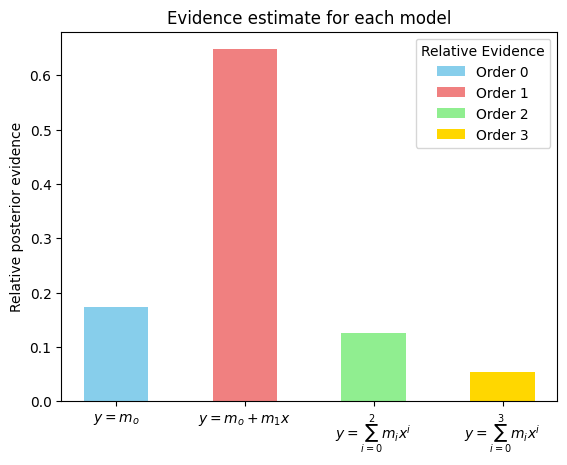

In [9]:
# plot evidence values

fig, ax = plt.subplots()

fruits = [
    r"$y=m_o$",
    r"$y=m_o + m_1x$",
    r"$y = \sum_{i=0}^2 m_ix^i$",
    r"$y = \sum_{i=0}^3 m_ix^i$",
]
counts = [Ev[i] for i in range(maxorder + 1)]
bar_labels = [
    "Order 0",
    "Order 1",
    "Order 2",
    "Order 3",
]  # Define a list of labels, one for each bar

bar_colors = [
    "skyblue",
    "lightcoral",
    "lightgreen",
    "gold",
]  # Define a list of colors, one for each bar

ax.bar(fruits, counts, label=bar_labels, width=0.5, color=bar_colors)

ax.set_ylabel("Relative posterior evidence")
ax.set_title("Evidence estimate for each model")
ax.legend(title="Relative Evidence")
# plt.savefig('Anal_evidence.pdf')

plt.show()

In [10]:
Ev

array([0.17305995, 0.64751747, 0.12509365, 0.05432893])

----------------

### Log-posterior Likelihood, prior and PDF for each state

In [11]:
# Create partial function binding data parameters for likelihood
log_likelihood = partial(_log_likelihood, dobs=dobs, G=G, Cdinv=Cdinv)

In [12]:
# Create partial function binding prior parameters
log_prior = partial(_log_prior, muprior=muprior, Cmprior=Cmprior)

In [13]:
# Create partial function binding all data and prior parameters for posterior
# This makes log_posterior(x, state) which is needed for optimization and MCMC
log_posterior = partial(
    _log_posterior_full, dobs=dobs, G=G, Cdinv=Cdinv, muprior=muprior, Cmprior=Cmprior
)

### Starting points for MCMC samplers in each state

In [14]:
# first we optimize each state to find good starting point for all McMC samplers
rng = np.random.default_rng(42)
nstates = maxorder + 1  # Number of distinct states
ndims = [1, 2, 3, 4]  # Number of model parameters in each state
nsamples_es = 4 * [10000]  # number of samples per chain for sampling of each state
nwalkers_es = 4 * [32]     # number of mcmc chains to run in each state
nll = lambda *args: -log_posterior(*args)
pos_pseudo,ml = [],[]
print("Maximum likelihood estimates:")
for i in range(nstates):
    initial = 0.5 * np.ones(i + 1)
    soln = minimize(nll, initial, args=(i,))
    ml.append(soln.x)
    pos_pseudo.append(soln.x + 1e-4 * rng.standard_normal((nwalkers_es[i], ndims[i])))
    print("x_ml ", soln.x)

Maximum likelihood estimates:
x_ml  [0.58148024]
x_ml  [0.37788932 0.48664354]
x_ml  [ 0.31354801  0.95796058 -0.52400541]
x_ml  [ 0.28548373  1.4395107  -1.83289387  0.89632873]


### Build pseudo priors by fitting a Gaussian mixture to posterior ensembles in each state

Fit a mixture model in each state to create a log-pseudo prior function. This uses the provided utility `build_auto_pseudo_prior()` which takes in posterior ensembles `ensemble_per_state[s],s=1,...,nstates` and returns a function to evaluate the log-pseudo prior PDF. This routine is passed to the product space sampler `run_state_jump_sampler`. 

Alternatively the user may create their own `log_pseudo_prior(x, state)` function provided it evaluates a normalized PDF in each state and has this call sequence, where `x` is a model vector in state `state`. An option is to set it to the prior `log_pseudo_prior = log_prior`.

#### Parallelised sampling over each state
`run_mcmc_per_state` performs posterior sampling within each state using MCMC. Since this process is *embarrasingly parallel* over states, and may separately be parallelized across chains within each state, we expose two pools that the user may define. One over states and one over walkers. Both may be used simultaneously. This is implemented using the following options:

- `parallel_mode = 0` :Sequential execution (no pool).
- `parallel_mode = 1` :Parallel across states only. Set `n_state_procs` to a factor of the number of states.
- `parallel_mode = 2` :Parallel across states and walkers within each state. Set `n_state_procs` to a factor of the number of states and  `n_walker_procs` to a factor of the number of walkers within each state.

In [15]:
parallel_mode = 1      # Implement choice of Parallel mode
if (parallel_mode == 1):
    n_state_procs = 4  # Number of processes used in state mode. Suggest set equal to number of states if possible.
elif(parallel_mode == 2):
    n_state_procs = 4  # Number of processes over states. Suggest set equal to number of states if possible.
    n_walker_procs = 8 # Number of processes used over walkers within each state

In [16]:
# run Ensemble sampler in each state
start_time = time.time()
if(parallel_mode == 0): # No parallelisation
    ensemble_per_state, log_posterior_ens = run_mcmc_per_state(
        nstates,  # number of states
        ndims,  # number of dimensions in each state
        nwalkers_es,  # int or list containing number of walkers for each state
        nsamples_es,  # number of chain steps per walker
        pos_pseudo,  # starting positions for walkers in each state
        log_posterior,  # log posterior (likelihood x prior)
        discard=0,  # burnin number of chain steps to discard in eeach state
        auto_thin=True,  # thinning value, save every `thin` models
        verbose=True)  # show progress bar for each state

elif(parallel_mode == 1): # Parallel over states only
    with ProcessPoolExecutor(max_workers=n_state_procs) as state_pool:
            ensemble_per_state, log_posterior_ens = run_mcmc_per_state(
                nstates,
                ndims,
                nwalkers_es,
                nsamples_es,
                pos_pseudo,
                log_posterior,
                discard=0,
                state_pool=state_pool,
                auto_thin=True
            )
elif(parallel_mode == 2): # Parallel over states and walkers
    with ProcessPoolExecutor(max_workers=n_state_procs) as state_pool, \
         ProcessPoolExecutor(max_workers=n_walker_procs) as walker_pool:
    
        ensemble_per_state, log_posterior_ens = run_mcmc_per_state(
            nstates,
            ndims,
            nwalkers_es,
            nsamples_es,
            pos_pseudo,
            log_posterior=log_posterior,
            state_pool=state_pool,
            emcee_pool=walker_pool,
            auto_thin=True
        )

elapsed_time = time.time() - start_time
print(
    " Elapsed time                                     :",
    np.round(elapsed_time, 2),
    "s \n",
)
print(
    " Number of samples in each state                  :",
    *[len(ensemble_per_state[i]) for i in range(nstates)],
)


Running within-state sampler separately on each state

Number of walkers               :  [32, 32, 32, 32]

Number of states being sampled:  4
Dimensions of each state:  [1, 2, 3, 4]
Using state-level parallelism


100%|██████████| 10000/10000 [00:23<00:00, 423.10it/s]


Performing auto thinning of ensemble...
 Elapsed time                                     : 24.23 s 

 Number of samples in each state                  : 22854 19997 15996 13909


Now use the utility routine to create a log-pseudo prior function.

In [17]:
log_pseudo_prior = build_auto_pseudo_prior(ensemble_per_state=ensemble_per_state)

-----------

Now we are ready to apply the State-Jump sampler with walker pool parallelization.

## Trans-C sampling across model states with the State-Jump sampler and walker pool parallelization

Here we demonstrate use of the *State-jump sampler* with walker pool parallelization.

This formulation is equivalent to the *Product-space sampler* with the proposal for the other state variables equal to the pseudo prior, for which moves are then accepted with probability one. As a consequence  the only pair of model states that need be considered are the $k$ and $k^{\prime}$ states (i.e. same as in Reversible-Jump). 

- For within-state moves the acceptance is the usual M-H condition with proposal = to users choice for that state, defined by routine `log_proposal`
  This can be any perturbative proposal PDF designed by the user, or an automatic one found by fitting a Gaussian mixture model to some trial samples.

- For between-state moves we assume that only the state index changes, $k \rightarrow k^{\prime}$ , and hence the model in state $k^{\prime}$ must be a draw from the pseduo prior for that state. The acceptance term then only involves the likelihood ratio and the pseudo prior ratio for the two states.

**Walker Pool Parallelization**: Each walker runs independently and can be parallelized across multiple processors using a user-provided pool as in the example below.

In [18]:
log_proposal = IsotropicGaussianProposal()

##  Trans-C samping across model states with the State-Jump sampler 

In [19]:
# starting points of MCMC chains
nwalkers_sj = 32  # Number of walkers
nsteps_sj = 10000  # Number of chain steps
pos_states = rng.choice(
    np.arange(nstates), nwalkers_sj
)  # Initial states of each walker
pos = []
for i in range(nwalkers_sj):  # generate starting points for each walker
    pos.append(
        ml[pos_states[i]] + 1e-4 * rng.standard_normal(ndims[pos_states[i]])
    )  # add random perturbation to maximum Likelihood models

#### Parallelised state-jump sampler
`run_state_jump_sampler` performs posterior sampling over the Trans-C space. The parallelisation pool is exposed in the calling seuqence, allowing the user to control the pool if desired. Here we demonstrate serial and walker parallelization.

- `parallel_mode = 0` :Sequential execution (no pool).
- `parallel_mode = 1` :Parallel across walkersused by State-jump sampler. Set `n_walker_procs` to a factor of the number of walkers.


In [20]:
parallel_mode = 0  # serial
parallel_mode = 1  # parallelization over walkers
n_walker_procs = 8 # Number of processes used over walkers in state-jump sampling

In [21]:
# Serial execution for baseline
start_time = time.time()
if(parallel_mode==0): # Sequential execution (no pool)
    print("\n=== SERIAL EXECUTION ===")
    state_jump_chains = run_state_jump_sampler(
        nwalkers_sj,
        nsteps_sj,
        nstates,
        ndims,
        pos,
        pos_states,
        log_posterior,
        log_pseudo_prior,
        log_proposal,
        progress=True,
    )
    serial_time = time.time() - start_time

    print(f"Serial execution time: {serial_time:.2f} seconds")

elif(parallel_mode ==1): # Demonstrate parallel over 4 processes
    print("\n=== PARRALEL EXECUTION ===")
    with ProcessPoolExecutor(max_workers=n_walker_procs) as walker_pool:
        state_jump_chains = run_state_jump_sampler(
                nwalkers_sj,
                nsteps_sj,
                nstates,
                ndims,
                pos,
                pos_states,
                log_posterior,
                log_pseudo_prior,
                log_proposal,
                walker_pool=walker_pool,
                progress=True,
            )
    parallel_time = time.time() - start_time

    print(f"Parallel execution time: {parallel_time:.2f} seconds")

alg = "TransC-state-jump-sampler"
state_chain_tot = np.swapaxes(state_jump_chains.state_chain_tot, 0, 1)
state_chain = state_jump_chains.state_chain.T
model_chain = state_jump_chains.model_chain
accept_within_per_walker = (
    state_jump_chains.accept_within / state_jump_chains.prop_within
)
accept_between_per_walker = (
    state_jump_chains.accept_between / state_jump_chains.prop_between
)
accept_within = 100 * np.mean(accept_within_per_walker)
accept_between = 100 * np.mean(accept_between_per_walker)

2025-10-15 17:27:11 [INFO] pytransc.samplers.state_jump: Running state-jump trans-C sampler
2025-10-15 17:27:11 [INFO] pytransc.samplers.state_jump: Number of walkers: 32
2025-10-15 17:27:11 [INFO] pytransc.samplers.state_jump: Number of states being sampled: 4
2025-10-15 17:27:11 [INFO] pytransc.samplers.state_jump: Dimensions of each state: [1, 2, 3, 4]



=== PARRALEL EXECUTION ===


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:10<00:00,  3.15it/s]


Parallel execution time: 10.40 seconds


In [22]:
# print some diagnostics
print("\n Algorithm type                                   :", alg)
# extract trans-D samples and chains
discard = 0  # chain burnin
thin = 20  # chain thinning
visits, states_chain = get_visits_to_states(
    transc_sampler=state_jump_chains,
    discard=discard,
    thin=thin,
    normalize=True,
)
visits = visits.swapaxes(0, 1)  # (n_steps, n_walkers, n_states)
states_chain = states_chain.swapaxes(0, 1)  # (n_steps, n_walkers)

state_changes_per_walker = count_state_changes(
    state_jump_chains.state_chain, discard=discard, thin=thin
)
total_state_changes = count_total_state_changes(
    state_jump_chains.state_chain, discard=discard, thin=thin
)
acceptance_rate_between_states = get_acceptance_rate_between_states(
    state_jump_chains, discard=discard, thin=thin
)
autocorr_time_for_between_state_jumps = get_autocorr_between_state_jumps(
    state_jump_chains.state_chain
)
relative_marginal_likelihoods = get_relative_marginal_likelihoods(
    state_jump_chains.state_chain_tot[:, -1, :]
)

print("\n Total number of state changes for all walkers    :", total_state_changes)
print(
    "\n Number of state changes for each walker          :\n",
    *state_changes_per_walker,
)
print(
    "\n Acceptance rates for walkers within states:  \n",
    accept_within_per_walker,
    "\n",
)
print(
    " Acceptance rates for walkers between states: \n",
    accept_between_per_walker,
    "\n",
)
print(
    " Average % acceptance rate for within states      :",
    np.round(accept_within, 2),
)
print(
    " Average % acceptance rate for between states     :",
    np.round(accept_between, 2),
)
print(
    " Auto correlation time for between state sampling :",
    np.round(autocorr_time_for_between_state_jumps, 3),
)
print(" Analytical relative marginal Likelihoods         :", *np.round(Ev, 5))
print(
    " Estimated relative evidences                     :",
    *np.round(relative_marginal_likelihoods, 5),
)
print(
    " Elapsed time.                                    :",
    np.round(elapsed_time, 2),
    "s \n",
)


 Algorithm type                                   : TransC-state-jump-sampler

 Total number of state changes for all walkers    : 6320

 Number of state changes for each walker          :
 214 199 194 196 184 203 187 191 217 181 206 190 198 204 190 202 189 190 178 203 190 189 177 194 178 209 208 224 227 221 175 212

 Acceptance rates for walkers within states:  
 [0.76222371 0.75248509 0.7590737  0.75394357 0.74541616 0.75166593
 0.76578772 0.75980883 0.74489569 0.73774293 0.74292035 0.75105767
 0.75926541 0.74802624 0.74220397 0.76593151 0.75441716 0.75060881
 0.76240937 0.7449911  0.76255556 0.76155556 0.75583204 0.76136744
 0.76838724 0.74573816 0.76332813 0.7453125  0.75253256 0.74608116
 0.75547405 0.74830084] 

 Acceptance rates for walkers between states: 
 [0.41362764 0.41437632 0.38899804 0.39679359 0.37862138 0.38955823
 0.3973306  0.37387836 0.42813765 0.37605932 0.40520833 0.37131631
 0.40062435 0.39622642 0.37714863 0.38792221 0.37762238 0.39026915
 0.35748792 0.39074803

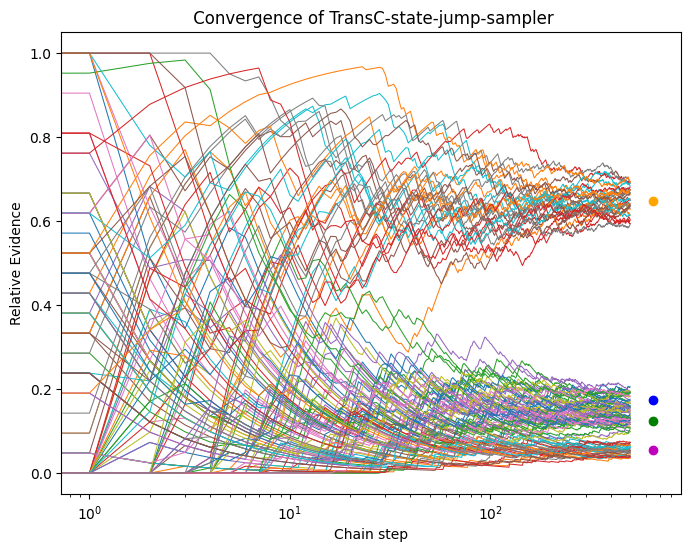

In [23]:
# plot relative number of visits to each state along the chain
plotting = True
if plotting:
    fig, axes = plt.subplots(figsize=(8, 6))
    if visits.ndim == 3:  # plot chains for each state and walker
        plt.semilogx(visits.reshape(np.shape(visits)[0], -1), lw=0.75)
    elif visits.ndim == 2:  # plot chains for each state average over walkers
        plt.semilogx(
            visits.reshape(np.shape(visits)[0], -1),
            lw=0.75,
            label=["State 1", "State 2", "State 3"],
        )
        plt.legend()
    plt.xlabel("Chain step")
    plt.ylabel("Relative Evidence")
    plt.plot(len(visits) * 1.3, Ev[0], "bo")
    plt.plot(len(visits) * 1.3, Ev[1], "o", color="orange")
    plt.plot(len(visits) * 1.3, Ev[2], "go")
    plt.plot(len(visits) * 1.3, Ev[3], "mo")
    plt.title(" Convergence of " + alg)
    # plt.savefig('SJ_chains.pdf')
    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. As you can see the chains are 
converging, and visiting each state in proportion to the correct normalization constant. 

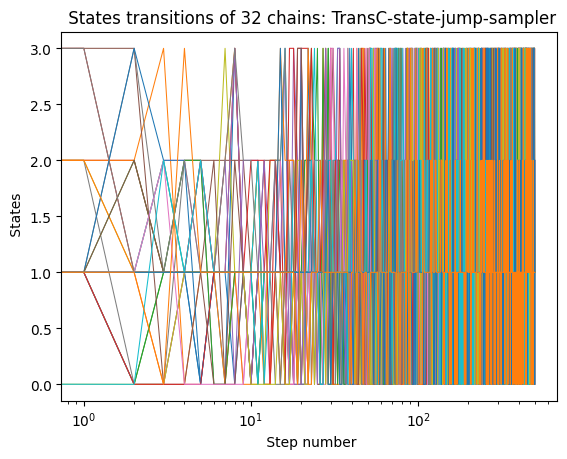

In [24]:
# plot chain states
if plotting:
    # plot chains for each state and walker
    plt.semilogx(states_chain.reshape(np.shape(states_chain)[0], -1), lw=0.75)
    plt.xlabel(" Step number")
    plt.ylabel(" States")
    title = " States transitions of " + str(nwalkers_sj) + " chains: " + alg
    plt.title(title)
    # plt.savefig('SJ_chain_transistions.pdf')
    plt.show()

This plot shows the movement of each chain between states.

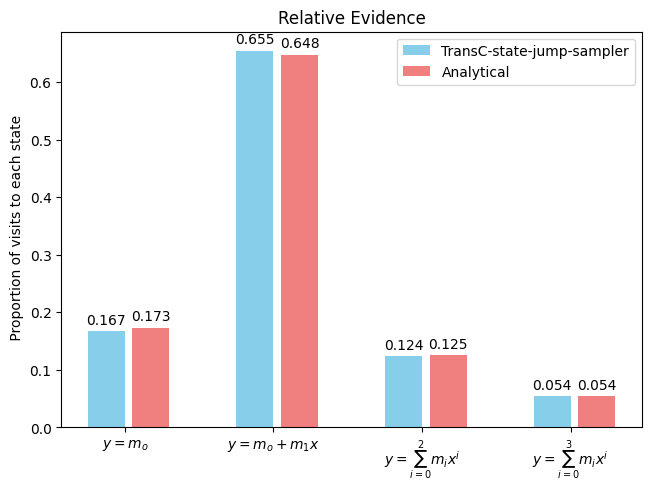

In [25]:
# Count visits to each state by Trans-D mcmc
if plotting:
    h = np.zeros(nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(
        Counter(states_chain.reshape(-1)).values()
    )
    h /= np.sum(h)
    # plot histogram of frequency of visits to each state

    labels = [
        r"$y=m_o$",
        r"$y=m_o + m_1x$",
        r"$y = \sum_{i=0}^2 m_ix^i$",
        r"$y = \sum_{i=0}^3 m_ix^i$",
    ]
    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained")
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h, 3), width, label=alg, color="skyblue")
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier + 0.05
    rects = ax.bar(
        x + offset, np.round(counts, 3), width, label="Analytical", color="lightcoral"
    )
    ax.bar_label(rects, padding=3)
    multiplier += 1
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(" Proportion of visits to each state")
    ax.set_title("Relative Evidence")
    ax.set_xticks(x + width / 2, labels)
    ax.legend(loc="upper right")
    # plt.savefig('SJ_relative_evidences.pdf')
    plt.show()

 State;  1  in  2  dimensions
 State;  2  in  3  dimensions
 State;  3  in  4  dimensions


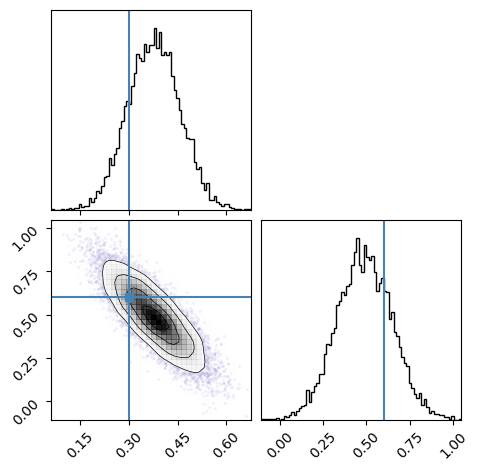

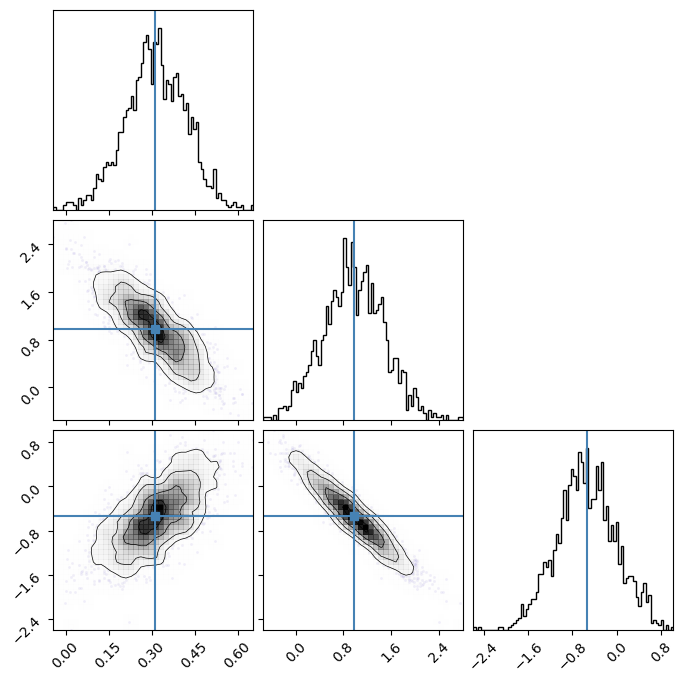

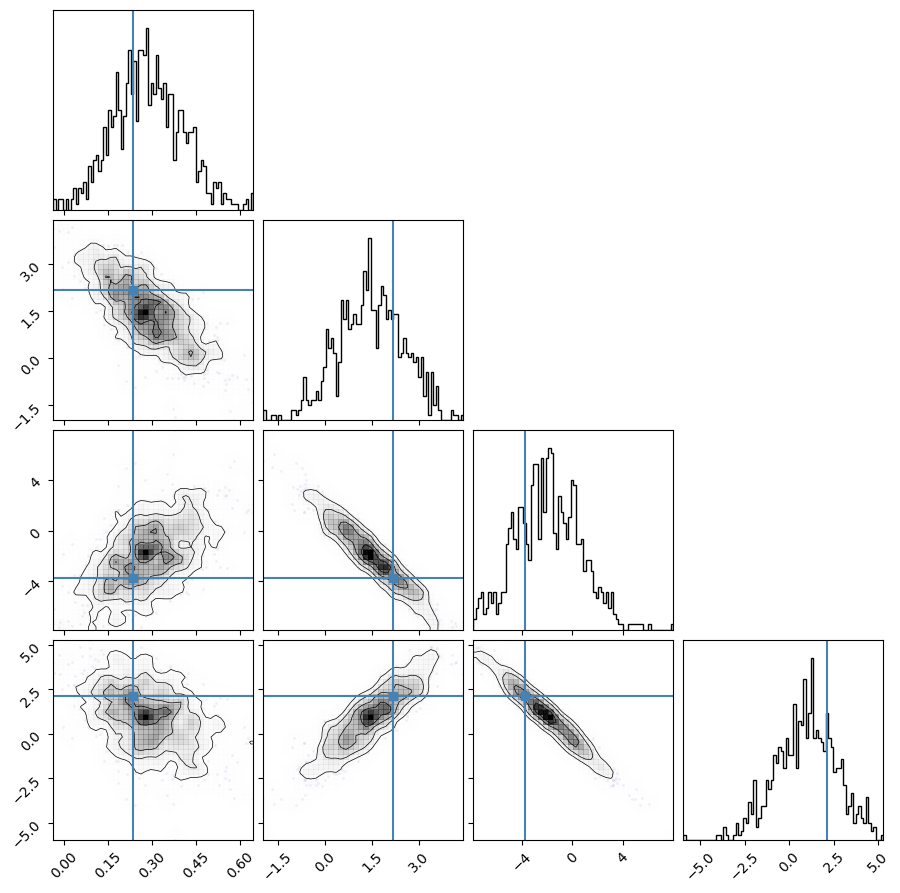

In [26]:
# corner plots to check sampling within each state
if plotting:
    muplot = mls.copy()
    muplot[1] = mtrue
    # collect trans samples
    transc_ensemble = get_transc_samples(
        state_jump_chains,
        discard=0,
        thin=thin,
    )
    contour_kwargs = {"linewidths": 0.5}
    data_kwargs = {"color": "slateblue"}
    for i in range(1, nstates):
        string = "Order " + str(i)
        print(" State; ", i, " in ", ndims[i], " dimensions")
        fig = corner.corner(
            transc_ensemble[i],
            truths=muplot[i],
            title=string,
            bins=40,
            hist_bin_factor=2,
            smooth=True,
            contour_kwargs=contour_kwargs,
            data_kwargs=data_kwargs,
        )
        # fig.savefig("SJ_corner_" + str(i) + ".pdf")

In [27]:
print(
    f" Here is the Trans-C ensemble with\n {len(transc_ensemble[0])} samples in state 1\n {len(transc_ensemble[1])} samples in state 2\n {len(transc_ensemble[2])} samples in state 3\n",
    "\n",
    transc_ensemble,
)

 Here is the Trans-C ensemble with
 2676 samples in state 1
 10478 samples in state 2
 1980 samples in state 3
 
 [array([[0.55992779],
       [0.55999963],
       [0.57913187],
       ...,
       [0.53573514],
       [0.58296182],
       [0.60603697]], shape=(2676, 1)), array([[0.44887425, 0.40627714],
       [0.49250525, 0.37275255],
       [0.43921334, 0.29890947],
       ...,
       [0.5422382 , 0.31891428],
       [0.42140077, 0.48816628],
       [0.51579877, 0.2576049 ]], shape=(10478, 2)), array([[ 0.31342636,  0.95789347, -0.52397421],
       [ 0.41073515,  0.1578636 ,  0.2608487 ],
       [ 0.50328469,  0.43394284, -0.22912258],
       ...,
       [ 0.56374229,  0.49090784, -0.26687101],
       [ 0.27268683,  1.32426329, -0.83656759],
       [ 0.28582793,  1.38092499, -1.26667468]], shape=(1980, 3)), array([[ 0.29404222,  2.03850352, -2.92986744,  1.08811146],
       [ 0.1607692 ,  3.03971909, -5.01099743,  2.3868421 ],
       [ 0.33129475,  0.86131329, -0.31844448, -0.0753461